In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pickle
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Constants
MAX_WORDS = 50000  # Maximum vocabulary size
MAX_LEN = 200     # Maximum sequence length
EMBEDDING_DIM = 300  # Embedding dimension
BATCH_SIZE = 32
EPOCHS = 15

# Define sentiment words
POSITIVE_WORDS = {
    "amazing", "brilliant", "fantastic", "excellent", "masterpiece", "incredible", "outstanding", "engaging",
    "captivating", "enthralling", "emotional", "heartfelt", "touching", "inspiring", "uplifting", "thought-provoking",
    "intelligent", "well-executed", "well-directed", "well-acted", "powerful", "groundbreaking", "iconic",
    "unforgettable", "superb", "remarkable", "beautiful", "stunning", "visually impressive", "cinematic excellence",
    "breathtaking", "immersive", "riveting", "must-watch", "compelling", "well-paced", "exceptional", "genius",
    "flawless", "seamless", "masterfully crafted", "Oscar-worthy", "top-notch", "well-written", "perfectly cast",
    "charming", "delightful", "hilarious", "witty", "clever", "fun", "entertaining", "joyful", "heartwarming",
    "satisfying", "rewarding", "mesmerizing", "phenomenal", "mind-blowing", "next-level", "out-of-this-world",
    "legendary", "awe-inspiring", "spectacular", "unparalleled", "artistic", "deep", "poignant", "memorable",
    "electrifying", "soul-stirring", "rich storytelling", "layered", "nuanced", "well-balanced", "thoughtful",
    "grounded", "relatable", "authentic", "high-quality", "brilliantly executed", "visually stunning",
    "cinematic masterpiece", "edge-of-your-seat", "game-changing", "unmatched", "daring", "effortlessly engaging",
    "enchanting", "bold", "charismatic", "gripping", "thrilling", "timeless", "believable", "genuine",
    "well-crafted", "deeply moving", "innovative", "sensational", "highly recommended", "strong performances",
    "great chemistry", "compelling story", "visually breathtaking", "stunning cinematography", "perfectly paced",
    "incredible acting", "masterful storytelling", "engrossing", "edge-of-seat", "intensely satisfying","love"
}

NEGATIVE_WORDS = {
    "boring", "slow", "predictable", "cliché", "overrated", "disappointing", "unoriginal", "dull", "cringe",
    "forced", "confusing", "awful", "messy", "weak", "flat", "unrealistic", "cheesy", "annoying", "lame",
    "forgettable", "terrible", "unwatchable", "lifeless", "horrible", "flawed", "pointless", "stupid",
    "overlong", "bad acting", "poor writing", "waste of time", "incoherent", "frustrating", "lazy",
    "overdramatic", "underwhelming", "unfunny", "mediocre", "repetitive", "bland", "wooden", "shallow",
    "chaotic", "generic", "nonsensical", "too predictable", "low-quality", "overhyped", "dragging",
    "illogical", "forced humor", "annoying characters", "unconvincing", "overacted", "emotionless",
    "forgettable soundtrack", "poor execution", "unrealistic dialogue", "rushed ending", "too long",
    "no depth", "unnecessary twists", "lackluster", "too dark", "over-explained", "miscast", "overcomplicated",
    "too violent", "weak direction", "unengaging", "hate", "horrendous", "atrocious", "pathetic", "disgusting",
    "detestable", "abominable", "repulsive", "appalling", "offensive", "insulting", "cringeworthy", "intolerable",
    "unbearable", "nauseating", "painful", "excruciating", "mind-numbing", "sickening", "grating", "abhorrent",
    "ridiculous", "dreadful", "infuriating", "meaningless", "soulless", "depressing", "tiresome",
    "tedious", "frustratingly bad", "garbage", "dumpster fire", "zero effort", "wretched", "irritating", "shoddy",
    "atrocity", "nightmarish", "shameful", "laughable", "crappy", "pathetically bad", "eye-roll inducing", "painstakingly bad",
    "poorly executed", "clumsy", "tone-deaf", "pointlessly edgy", "unnecessarily dramatic", "overblown", "exaggerated",
    "try-hard", "awkward", "corny", "ham-fisted", "unintentionally funny", "farcical", "botched", "silly in a bad way",
    "dragging pace", "overacted performances", "misused potential", "horrible CGI", "poor character development",
    "flat dialogue", "overstuffed plot", "pointlessly stretched", "failed execution", "script issues",
    "annoying soundtrack", "unconvincing performances", "choppy editing", "lacking tension", "directionless",
}

In [ ]:
def clean_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = str(text).lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters but keep negative contractions
    text = re.sub(r'[^a-zA-Z\s\']+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Handle negative contractions
    text = text.replace('\'t', ' not')

    # Remove stopwords except 'not' and 'no'
    stop_words = set(stopwords.words('english')) - {'no', 'not'}
    words = [w for w in text.split() if w not in stop_words]

    return ' '.join(words)

In [ ]:
# Load and preprocess data
print("Loading and preprocessing data...")
df = pd.read_csv('/content/IMDB Dataset.csv')

# Clean the reviews
df['review'] = df['review'].apply(clean_text)

# Convert sentiment to binary
df['sentiment'] = (df['sentiment'] == 'positive').astype(int)

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['review'])

# Save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert texts to sequences and pad
sequences = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
y = df['sentiment'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Loading and preprocessing data...
Training samples: 40000
Testing samples: 10000


In [ ]:
def create_model():
    """Create the hybrid LSTM-CNN model"""
    inputs = Input(shape=(MAX_LEN,))

    # Embedding layer
    embedding = Embedding(MAX_WORDS, EMBEDDING_DIM)(inputs)
    embedding = Dropout(0.4)(embedding)

    # LSTM path
    lstm = Bidirectional(LSTM(256, return_sequences=True))(embedding)
    lstm = Dropout(0.4)(lstm)
    lstm = Bidirectional(LSTM(128))(lstm)

    # CNN paths
    conv1 = Conv1D(128, 3, activation='relu', padding='same')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu', padding='same')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    # Merge paths
    conv_merged = concatenate([pool1, pool2, pool3])
    conv_flat = LSTM(128)(conv_merged)

    # Combine paths
    merged = concatenate([lstm, conv_flat])
    merged = Dropout(0.4)(merged)

    # Dense layers
    dense = Dense(256, activation='relu')(merged)
    dense = Dropout(0.4)(dense)
    dense = Dense(128, activation='relu')(dense)
    dense = Dropout(0.4)(dense)

    outputs = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 300)       │     15,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 200, 300)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 128)       │        115,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 128)       │        153,728 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 128)       │        192,128 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 200, 512)       │      1,140,736 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 100, 128)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 100, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 100, 128)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200, 512)       │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100, 384)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        656,384 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 128)            │        262,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 384)            │              0 │ bidirectional_1[0][0], │
│ (Concatenate)             │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)  

 Total params: 17,652,545 (67.34 MB)

 Trainable params: 17,652,545 (67.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# Train
print("Training model...")
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    shuffle=True
)

# Save the model
model.save('sentiment_model.h5')

Training model...
Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.6521 - loss: 0.6135 - val_accuracy: 0.8561 - val_loss: 0.3489 - learning_rate: 0.0010
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.8908 - loss: 0.2952 - val_accuracy: 0.8734 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 138s 80ms/step - accuracy: 0.9403 - loss: 0.1739 - val_accuracy: 0.8860 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 87s 84ms/step - accuracy: 0.9679 - loss: 0.1013 - val_accuracy: 0.8817 - val_loss: 0.2941 - learning_rate: 0.0010
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.9836 - loss: 0.0573 - val_accuracy: 0.8759 - val_loss: 0.3855 - learning_rate: 0.0010
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.9903 - loss: 0.0334 - val_accuracy: 0.8745 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 87

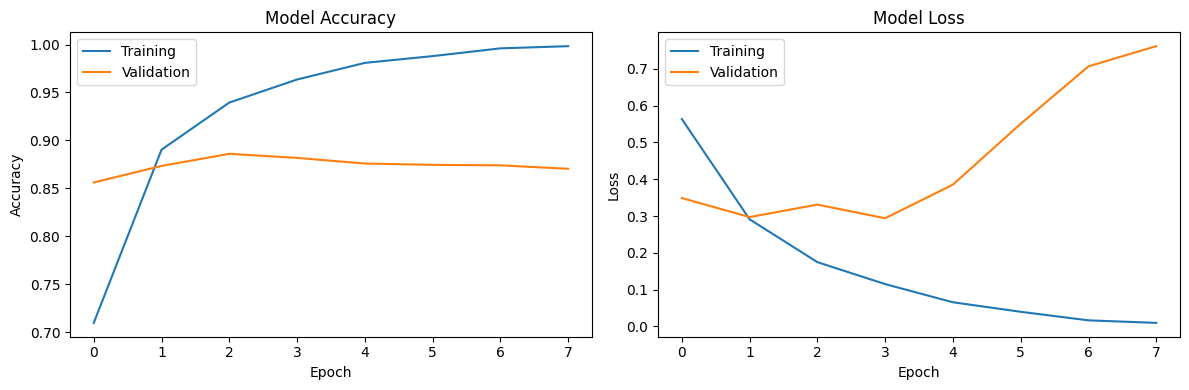

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8894 - loss: 0.2740

Test Accuracy: 0.8911


In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

In [ ]:
def predict_sentiment(text, model, tokenizer):
    # Clean text
    cleaned_text = clean_text(text)
    words = set(cleaned_text.split())

    # Check sentiment words
    neg_count = len(words.intersection(NEGATIVE_WORDS))
    pos_count = len(words.intersection(POSITIVE_WORDS))

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post')

    # Predict
    prediction = model.predict(padded, verbose=0)[0][0]

    # Adjust prediction based on sentiment words
    if neg_count > pos_count:
        prediction = prediction * 0.5
    elif pos_count > neg_count:
        prediction = min(prediction * 1.2, 1.0)

    # Determine sentiment and confidence
    if prediction > 0.8:
        sentiment = "Positive"
        confidence = prediction
    elif prediction < 0.2:
        sentiment = "Negative"
        confidence = 1 - prediction
    else:
        if prediction < 0.4:
            sentiment = "Slightly Negative"
        elif prediction > 0.6:
            sentiment = "Slightly Positive"
        else:
            sentiment = "Neutral"
        confidence = abs(prediction - 0.5) * 2

    return sentiment, float(confidence)

# Test examples
test_reviews = [
    "I hate it",
    "This is terrible",
    "I love this movie",
    "It was just okay",
    "This is the worst thing ever",
    "Absolutely brilliant performance"
]

# Load saved model and tokenizer
saved_model = load_model('sentiment_model.h5')
with open('tokenizer.pickle', 'rb') as handle:
    saved_tokenizer = pickle.load(handle)

print("Testing sentiment analysis:")
for review in test_reviews:
    sentiment, confidence = predict_sentiment(review, saved_model, saved_tokenizer)
    print(f"\nReview: {review}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2%}")

Testing sentiment analysis:

Review: I hate it
Sentiment: Slightly Negative
Confidence: 53.04%

Review: This is terrible
Sentiment: Negative
Confidence: 99.65%

Review: I love this movie
Sentiment: Slightly Positive
Confidence: 45.00%

Review: It was just okay
Sentiment: Negative
Confidence: 81.27%

Review: This is the worst thing ever
Sentiment: Negative
Confidence: 99.73%

Review: Absolutely brilliant performance
Sentiment: Positive
Confidence: 100.00%


In [ ]:
s="""The plot was all over the place, the acting was uninspired, and the special effects looked cheap. I don’t understand the hype—it’s two hours of my life I’ll never get back."""
print(predict_sentiment(s,saved_model,saved_tokenizer))

('Negative', 0.993643581867218)


In [ ]:
predict_sentiment("I hate it ",saved_model,saved_tokenizer)

('Slightly Negative', 0.5304217338562012)